# GLM: Mini-batch ADVI on hierarchical regression model
Unlike Gaussian mixture models, (hierarchical) regression models have independent variables. These variables affect the likelihood function, but are not random variables. When using mini-batch, we should take care of that. 

In [1]:
%matplotlib inline
import theano
theano.config.floatX = 'float64'
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('../data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())

Here, 'log_radon_t' is a dependent variable, while 'floor_t' and 'county_idx_t' determine independent variable.  

In [2]:
import theano.tensor as tt

log_radon_t = tt.vector()
log_radon_t.tag.test_value = np.zeros(1)
floor_t = tt.vector()
floor_t.tag.test_value = np.zeros(1)
county_idx_t = tt.ivector()
county_idx_t.tag.test_value = np.zeros(1, dtype='int32')

minibatch_tensors = [log_radon_t, floor_t, county_idx_t]

In [3]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx_t] + b[county_idx_t] * floor_t
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=log_radon_t)

Random variable 'radon_like', associated with 'log_radon_t', should be given to the function for ADVI to denote that as observations in the likelihood term. 

In [4]:
minibatch_RVs = [radon_like]

On the other hand, 'minibatches' should include the three variables above. 

In [5]:
def minibatch_gen(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data.log_radon.values[ixs],\
            data.floor.values[ixs],\
            data.county_code.values.astype('int32')[ixs]

minibatches = minibatch_gen(data)

total_size = len(data)

Then, run ADVI with mini-batch. 

In [6]:
means, sds, elbos = pm.variational.advi_minibatch(
    model=hierarchical_model, n=40000, minibatch_tensors=minibatch_tensors, 
    minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
    total_size=total_size, learning_rate=1e-2, epsilon=1.0
)

Average ELBO = -1,112.85: 100%|██████████| 40000/40000 [00:37<00:00, 1073.74it/s]
Finished minibatch ADVI: ELBO = -1,066.92


Check the trace of ELBO and compare the result with MCMC. 

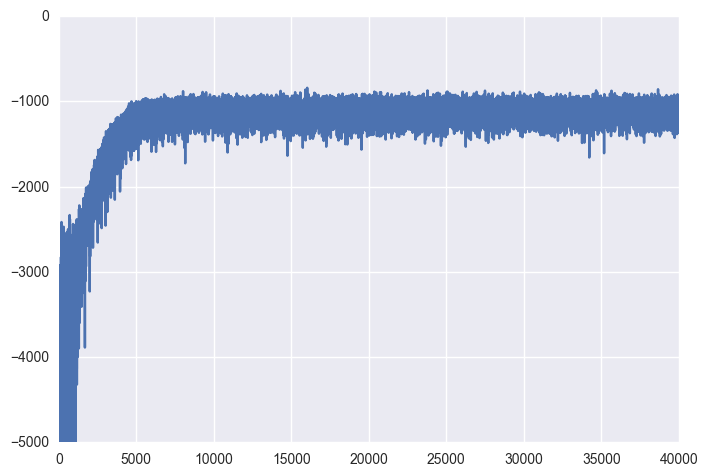

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(elbos)
plt.ylim(-5000, 0);

In [8]:
# Inference button (TM)!
with pm.Model():
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal(
        'radon_like', mu=radon_est, sd=eps, observed=data.log_radon.values)
    
    #start = pm.find_MAP()
    step = pm.NUTS(scaling=means)
    hierarchical_trace = pm.sample(2000, step, start=means, progressbar=False)

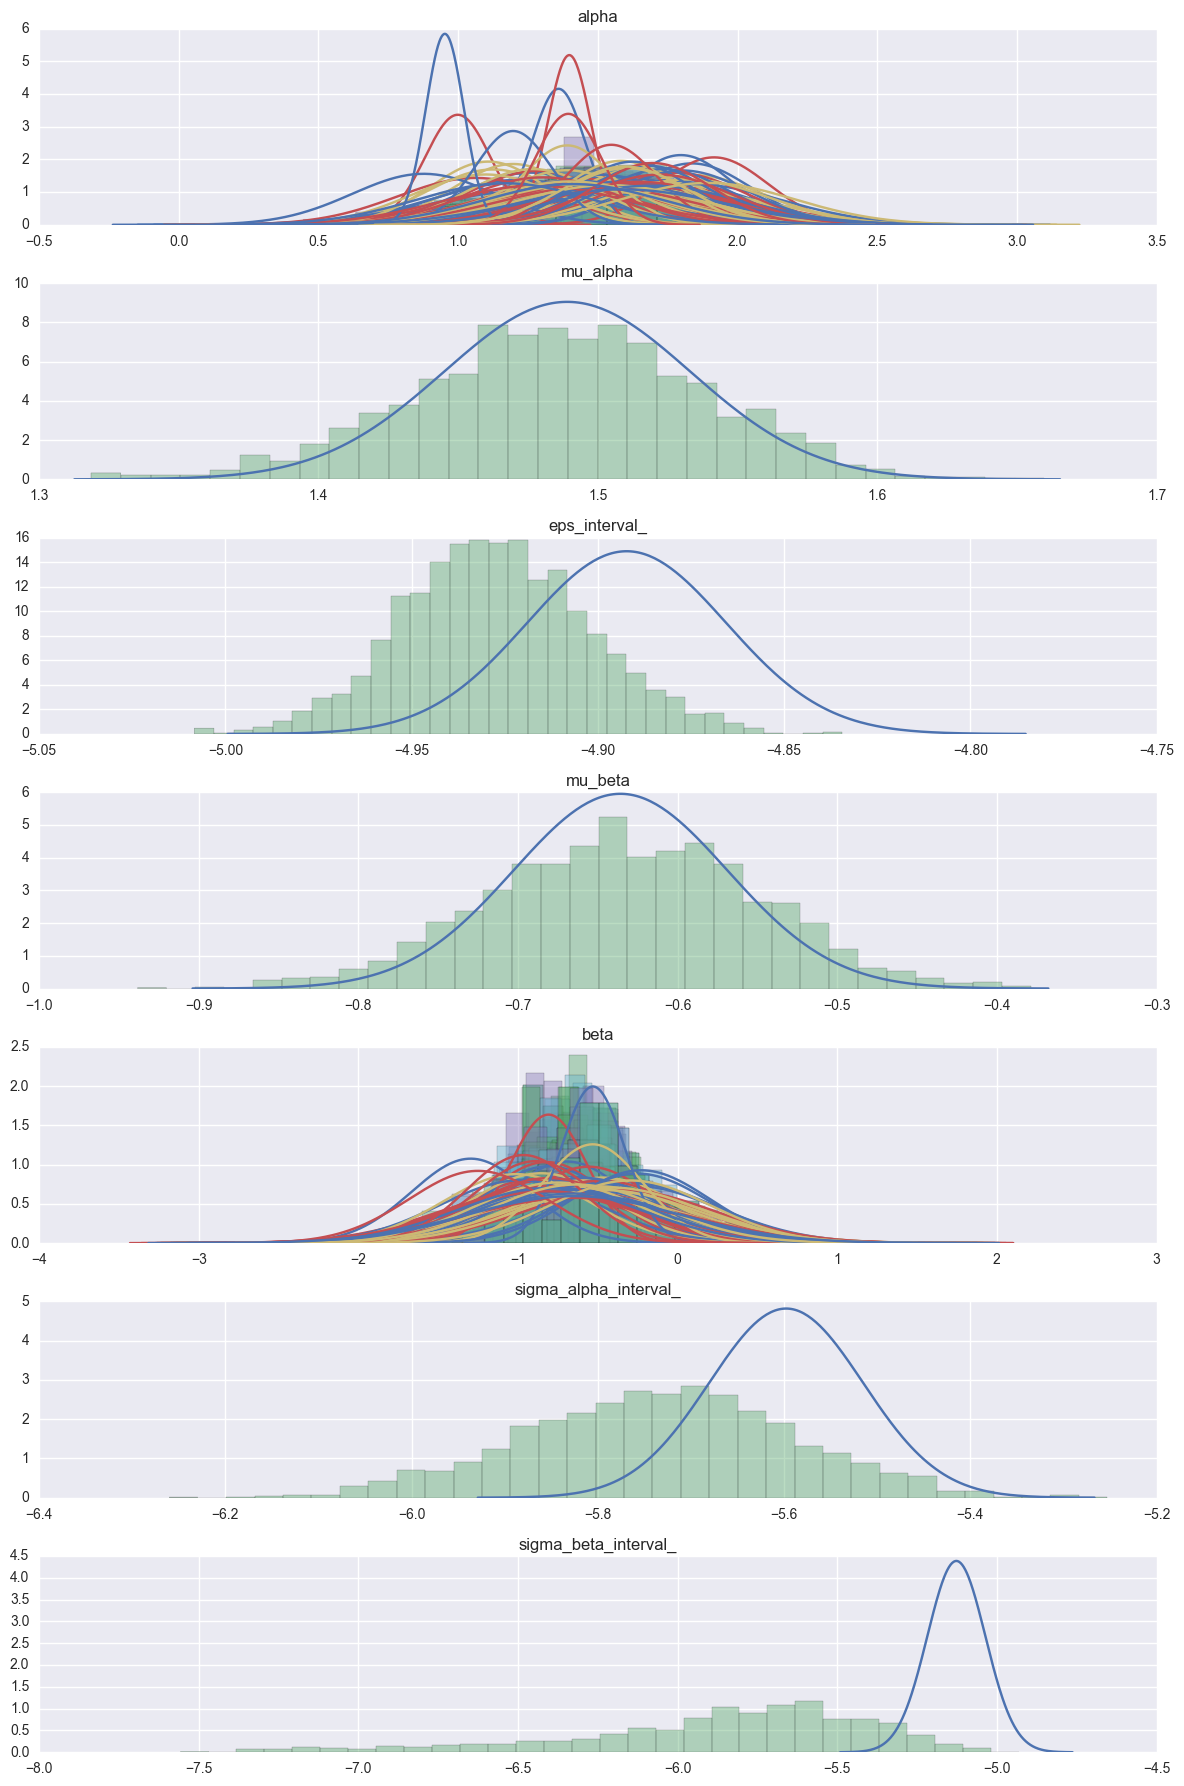

In [9]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()